# Unsupervised Learning - Clustering

The goal of clustering is to group similar instances together into clusters. Clustering is a great tool for data analysis, customer segmentation, recommender systems, search engines, image segmentation, semi-supervised learning, dimensionality reduction, and more.

This workshop is based on the book **Hands-on Machine Learning
with Scikit-Learn,Keras & TensorFlow**, 2nd Ed from Aurelien Geron. You can find the code on https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb. The videos are the online course **Machine Learning** from Andrew Ng, Standford University. While watching the videos, make notes of the parts that you don’t understand. We’ll discuss these in class.

Please watch the following videos (~60 min.): 
- [Clustering | Unsupervised Learning | Introduction](https://youtu.be/Ev8YbxPu_bQ) (3 min.). Concepts: Clustering.
- [Clustering | KMeans Algorithm](https://youtu.be/hDmNF9JG3lo) (12 min.). 
- [Clustering | Optimization Objectives](https://youtu.be/LvgcfMOyREE) (7 min.).
- [Clustering | Random Initialization](https://youtu.be/PpH_hv55GNQ) (8 min.).
- [Clustering | Choosing the right number of clusters](https://youtu.be/lbR5br5yvrY) (8 min.).
- [Clustering | IBM Machine Learning Coursera](https://www.coursera.org/learn/machine-learning-with-python/home/week/4) (20 min.)

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [238]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Clustering - case Description

## Introduction – Classification _vs_ Clustering

In [239]:
from sklearn.datasets import load_iris

Let us load the iris dataset. These flowers are not identical, yet they are sufficiently similar for you to know that they most likely belong to the same species (or at least the same genus). You may need a botanist to tell you what species that is, but you certainly don’t need an expert to identify groups of similar-looking objects. This is called clustering: it is the task of identifying similar instances and assigning them to clusters, or groups of similar instances.

In [240]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [241]:
import pandas as pd
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = pd.DataFrame(data.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


See figure on the left, a labeled dataset, for which classification algorithms such as Logistic Regression, SVMs, or Random Forest classifiers are well suited. On the right is the same dataset, but without the labels, so you cannot use a classification algorithm anymore. This is where clustering algorithms step in: many of them can easily detect the lower-left cluster. It is also quite easy to see with our own eyes, but it is not so obvious that the upper-right cluster is composed of two distinct sub-clusters. That said, the dataset has two additional features (sepal length and width), not represented here, and clustering algorithms can make good use of all features, so in fact they identify the three clusters fairly well

Saving figure classification_vs_clustering_plot


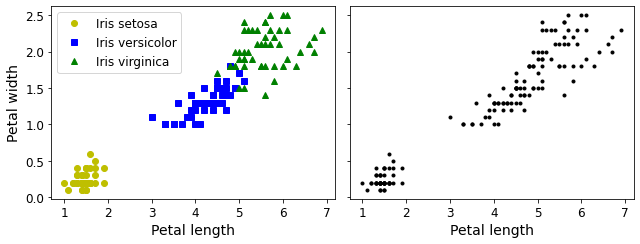

In [242]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

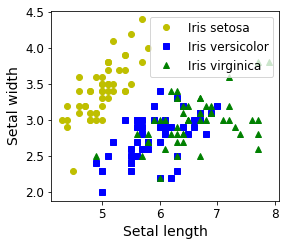

In [243]:
plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.xlabel("Setal length", fontsize=14)
plt.ylabel("Setal width", fontsize=14)
plt.legend(fontsize=12)

## K-Means

The K-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations. 

Let's start by generating some blobs. For more info on blobs https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

In [244]:
from sklearn.datasets import make_blobs

In [245]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [246]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Now let's plot them:

In [247]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


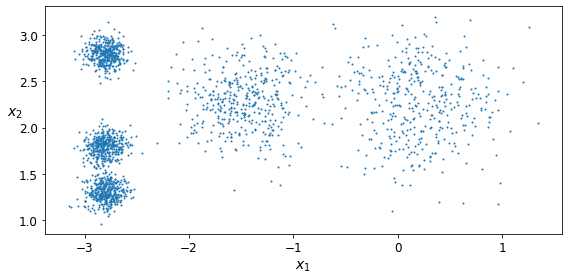

In [248]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

You can clearly see five blobs of instances. The K-Means algorithm is a simple algorithm capable of clustering
this kind of dataset very quickly and efficiently, often in just a few iterations

### Fit and Predict

Let's train a K-Means clusterer on this dataset. It will try to find each blob's center and assign each instance to the closest blob:

In [249]:
from sklearn.cluster import KMeans

Note that you have to specify the number of clusters k that the algorithm must find. In this example, it is pretty obvious from looking at the data that k should be set to 5, but in general it is not that easy

In [250]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the 5 clusters:

In [251]:
y_pred

array([0, 4, 1, ..., 2, 1, 4])

In the context of clustering, an **instance’s label'** is the index of the cluster that this instance gets assigned to by the algorithm: this is not to be confused with the class labels in classification (remember that clustering is an unsupervised learning task). Note that the `KMeans` instance preserves the labels of the instances it was trained on. 

In [252]:
y_pred is kmeans.labels_

True

And the following 5 _centroids_ (i.e., cluster centers) were estimated:

In [253]:
kmeans.cluster_centers_

array([[-2.80037642,  1.30082566],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80389616,  1.80117999]])

Of course, we can predict the labels of new instances:

In [254]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

### Decision Boundaries

Let's plot the model's decision boundaries. This gives us a **Voronoi diagram**:
For reference, a Voronoi diagram is a simple concept, and it's based on the minimal distance needed to reach a landmark - in our case the cluster centroid

In [255]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


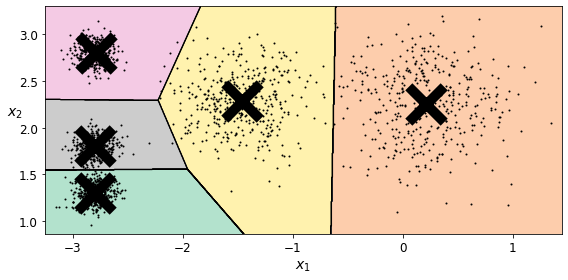

In [256]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Not bad! Some of the instances near the edges were probably assigned to the wrong cluster, but overall it looks pretty good. The K-Means algorithm does not behave very well when the blobs have very different diameters because all it cares about when assigning an instance to a cluster is the distance to the centroid.

### Hard Clustering _vs_ Soft Clustering

Rather than arbitrarily choosing the closest cluster for each instance (data point), which is called **hard clustering**, it might be better measure the distance of each instance to all 5 centroids. This is what the `transform()` method does:

In [257]:
kmeans.transform(X_new)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

You can verify that this is indeed the Euclidian distance between each instance and each centroid:

In [258]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.88633901, 0.32995317, 2.9042344 , 1.49439034, 2.81093633],
       [5.84236351, 2.80290755, 5.84739223, 4.4759332 , 5.80730058],
       [1.71086031, 3.29399768, 0.29040966, 1.69136631, 1.21475352],
       [1.21567622, 3.21806371, 0.36159148, 1.54808703, 0.72581411]])

In this example, the first instance in X_new is located at a distance of 2.81 from the first centroid, 0.33 from the second centroid, 2.90 from the third centroid, 1.49 from the fourth centroid, and 2.89 from the fifth centroid.

### K-Means Algorithm

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance (data point) to the closest centroid.
    * Now we have new clusters, that need centers. A centroid’s new value is going to be the mean of all the examples in a cluster.
    
Please check for more information : https://towardsdatascience.com/clustering-using-k-means-algorithm-81da00f156f6


The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. These hyperparameters will be explained below.
Resource : https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [259]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

And let's plot this:

Saving figure kmeans_algorithm_plot


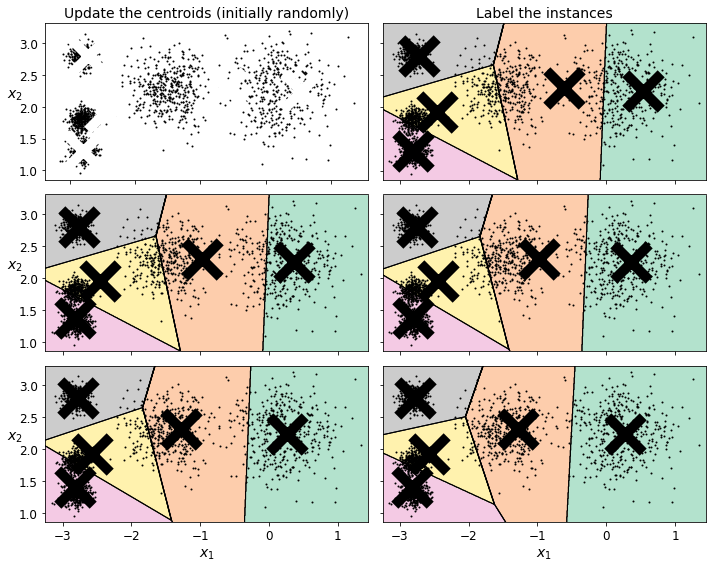

In [260]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### K-Means Variability

In the original K-Means algorithm, the centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

However, one major problem with this approach is that if you run K-Means multiple times (or with different random seeds), it can converge to very different solutions, as you can see below:

In [261]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

Saving figure kmeans_variability_plot


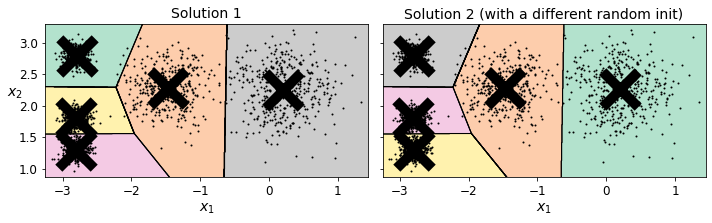

In [262]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", max_iter=5, random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", max_iter=5, random_state=19)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

You can try out different max_iter. Does it make a change?
Although the algorithm is guaranteed to converge, it may not converge to the right
solution (i.e., it may converge to a local optimum): whether it does or not depends on
the centroid initialization.

If you happen to know approximately where the centroids should be (e.g., if you ran
another clustering algorithm earlier), then you can set the init hyperparameter to a
NumPy array containing the list of centroids, and set n_init to 1:

In [263]:
 good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])


Saving figure kmeans_variability_plot


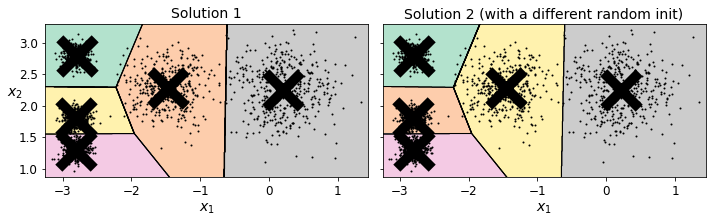

In [264]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init=good_init, n_init=1,
                         algorithm="full")

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

Another solution is to run the algorithm multiple times with different random initializations and keep the best solution. The number of random initializations is controlled by the **n_init hyperparameter** : by default, it is equal to 10, which means that the whole algorithm described earlier runs 10 times when you call fit(), and Scikit- Learn keeps the best solution. Try in the code above to use n_init=10 in kmeans_rnd_init1. Does it make a difference? ___________
But how exactly does it know which solution is the best? It uses a performance
metric! That metric is called the model’s inertia.

### Inertia

To select the best model, we will need a way to evaluate a K-Mean model's performance. Unfortunately, clustering is an unsupervised task, so we do not have the targets. But at least we can measure the distance between each instance (data point) and its centroid. This is the idea behind the _inertia_ metric:

In [265]:
kmeans.inertia_

211.5985372581683

As you can easily verify, inertia is the sum of the squared distances between each training instance and its closest centroid. This is also  called Within-Cluster-Sum-of-Squares (WCSS):

In [266]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.5985372581685

The `score()` method returns the negative inertia. Why negative? Well, it is because a predictor's `score()` method must always respect the "**greater is better**" rule.

In [267]:
kmeans.score(X)

-211.5985372581683

### Multiple Initializations

So one approach to solve the variability issue is to simply run the K-Means algorithm multiple times with different random initializations, and select the solution that minimizes the inertia. For example, here are the inertias of the two "bad" models shown in the previous figure:

In [268]:
kmeans_rnd_init1.inertia_

211.60832621558365

In [269]:
kmeans_rnd_init2.inertia_

211.62337889822365

As you can see, they have a higher inertia than the first "good" model we trained, which means they are probably worse.

When you set the `n_init` hyperparameter, Scikit-Learn runs the original algorithm `n_init` times, and selects the solution that minimizes the inertia. By default, Scikit-Learn sets `n_init=10`.

In [270]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=11)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=11)

As you can see, we end up with the initial model, which is certainly the optimal K-Means solution (at least in terms of inertia, and assuming $k=5$).

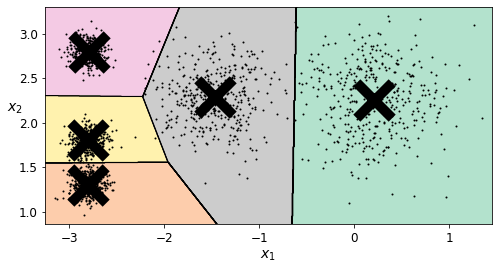

In [271]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

### K-Means++

Instead of initializing the centroids entirely randomly, it is preferable to initialize them using the following algorithm, proposed in a [2006 paper](https://goo.gl/eNUPw6) by David Arthur and Sergei Vassilvitskii:
* Take one centroid $c_1$, chosen uniformly at random from the dataset.
* Take a new center $c_i$, choosing an instance $\mathbf{x}_i$ with probability: $D(\mathbf{x}_i)^2$ / $\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2$ where $D(\mathbf{x}_i)$ is the distance between the instance $\mathbf{x}_i$ and the closest centroid that was already chosen. This probability distribution ensures that instances that are further away from already chosen centroids are much more likely be selected as centroids.
* Repeat the previous step until all $k$ centroids have been chosen.

The rest of the K-Means++ algorithm is just regular K-Means. With this initialization, the K-Means algorithm is much less likely to converge to a suboptimal solution, so it is possible to reduce `n_init` considerably. Most of the time, this largely compensates for the additional complexity of the initialization process.

To set the initialization to K-Means++, simply set `init="k-means++"` (this is actually the default):

In [272]:
KMeans()

KMeans()

In [273]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
#kmeans = KMeans(n_clusters=5, init=good_init, n_init=1,algorithm="full")
kmeans.fit(X)
kmeans.inertia_

211.59853725816828

### Accelerated K-Means

The K-Means algorithm can be significantly accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

To use Elkan's variant of K-Means, just set `algorithm="elkan"`. Note that it does not support sparse data, so by default, Scikit-Learn uses `"elkan"` for dense data, and `"full"` (the regular K-Means algorithm) for sparse data.

In [274]:
%timeit -n 50 KMeans(algorithm="elkan").fit(X)

68.4 ms ± 917 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [199]:
%timeit -n 50 KMeans(algorithm="full").fit(X)

176 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):
Instead of using the full dataset at each iteration, the algo‐ rithm is capable of using mini-batches, moving the centroids just slightly at each iter‐ ation. This speeds up the algorithm typically by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory.

In [200]:
from sklearn.cluster import MiniBatchKMeans

In [201]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [202]:
minibatch_kmeans.inertia_

211.93186531476786

Although the Mini-batch K-Means algorithm is much faster than the regular KMeans
algorithm, its inertia is generally slightly worse, especially as the number of
clusters increases

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5? So far, we have set the number of clusters k to 5 because it was obvious by looking at the data that this was the correct number of clusters. But in general, it will not be so easy to know how to set k, and the result might be quite bad if you set it to the wrong value. 

Saving figure bad_n_clusters_plot


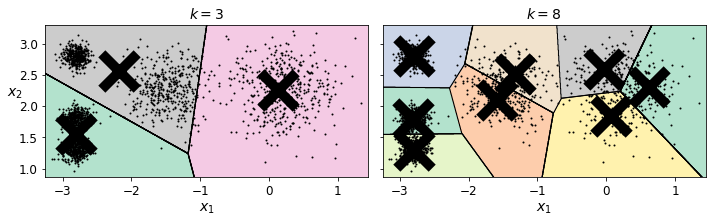

In [203]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. when k is too small, separate clusters get merged (left), and when k is too large, some clusters get chopped into multiple pieces (right). What about their inertias?

In [204]:
kmeans_k3.inertia_

653.2223267580945

In [205]:
kmeans_k8.inertia_

118.44108623570082

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

In [206]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
WCSS = [model.inertia_ for model in kmeans_per_k]

Saving figure inertia_vs_k_plot


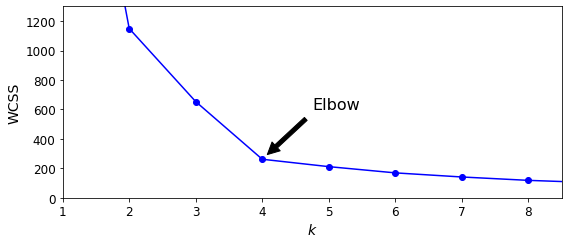

In [207]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), WCSS, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("WCSS", fontsize=14)
plt.annotate('Elbow',
             xy=(4, WCSS[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=4$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=4$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

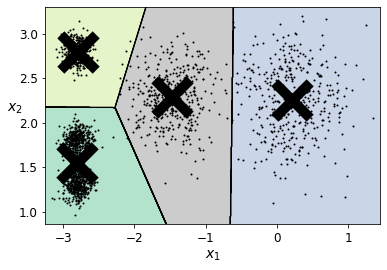

In [208]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

This technique for choosing the best value for the number of clusters is rather coarse. A more precise approach (but also more computationally expensive) is to use the silhouette score

The _silhouette score_ is the mean _silhouette coefficient_ over all the instances. An instance's silhouette coefficient is equal to $(b - a)/\max(a, b)$ where $a$ is the mean distance to the other instances in the same cluster (it is the _mean intra-cluster distance_), and $b$ is the _mean nearest-cluster distance_, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes $b$, excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

Let's plot the silhouette score as a function of $k$:

In [209]:
from sklearn.metrics import silhouette_score

In [210]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [211]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


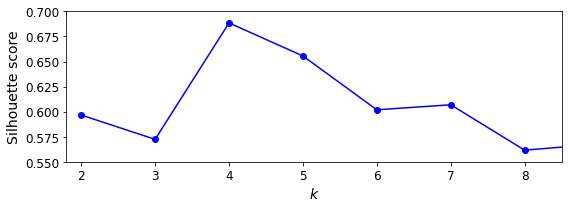

In [212]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

As you can see, this visualization is much richer than the previous one: in particular, although it confirms that $k=4$ is a very good choice, but it also underlines the fact that $k=5$ is quite good as well.

An even more informative visualization is given when you plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient. This is called a **silhouette diagram**:
Each diagram contains one knife shape per cluster. The shape’s height indicates the number of instances
the cluster contains, and its width represents the sorted silhouette coefficients of the
instances in the cluster (wider is better). The dashed line indicates the mean silhouette
coefficient.

Saving figure silhouette_analysis_plot


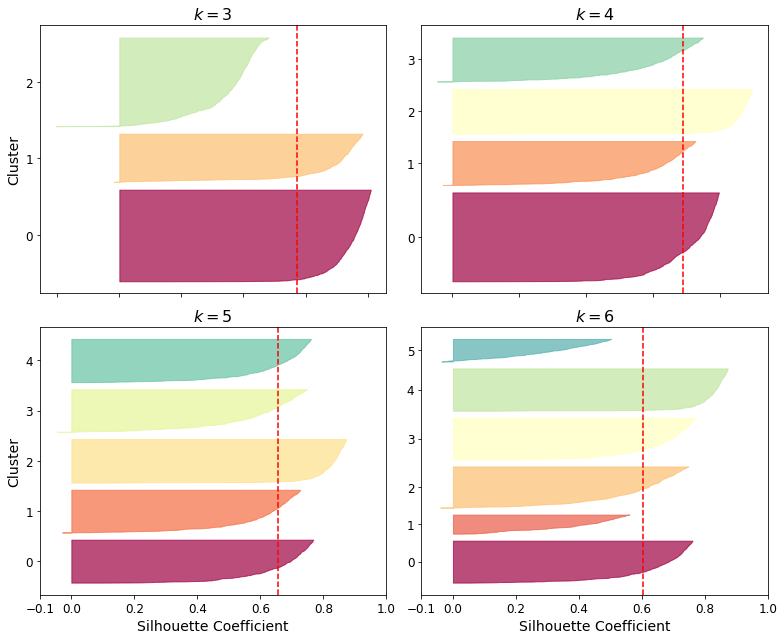

In [213]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

We can see that when k = 3 and when k = 6, we get bad clusters. But when k = 4 or k = 5, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to 1.0. When k = 4, the cluster at index 1 (the third from the top) is rather big. When k = 5, all clusters have similar sizes. So, even though the overall silhouette score from k = 4 is slightly greater than for k = 5, it seems like a good idea to use k = 5 to get clusters of similar sizes.

### Limits of K-Means

K-Means does not behave very well when the clusters have varying sizes, different densities, or nonspherical shapes.

In [214]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

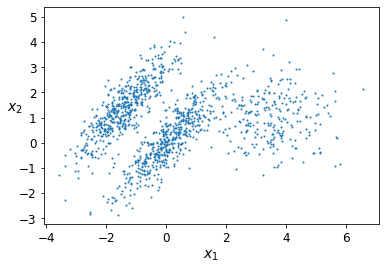

In [215]:
plot_clusters(X)

This example shows how K- Means clusters a dataset containing three ellipsoidal clusters of different dimensions, densities, and orientations.

In [216]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

Saving figure bad_kmeans_plot


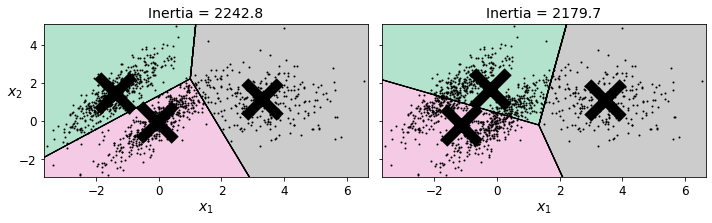

In [217]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

As you can see, neither of these solutions is any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it to the cluster on the right. The solution on the right is just terrible, even though its inertia is lower. So, depending on the data, different clustering algorithms may perform better. On these types of elliptical clusters, Gaussian mixture models work great.

## DBSCAN

let’s take a look at DBSCAN,
another popular clustering algorithm that illustrates a very different approach based
on local density estimation. This approach allows the algorithm to identify clusters of
arbitrary shapes.

In [218]:
from sklearn.datasets import make_moons

In [219]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

Saving figure moons


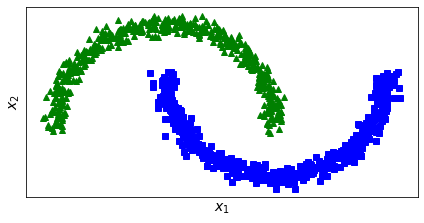

In [220]:
plt.figure(figsize=(6, 3.2))
# When the label y is 0, the class is represented with a blue square.
# When the label y is 1, the class is represented with a green triangle.
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "g^")

# X contains two features, x1 and x2
plt.xlabel(r"$x_1$", fontsize=14)
plt.ylabel(r"$x_2$", fontsize=14)

# Simplifying the plot by removing the axis scales.
plt.xticks([])
plt.yticks([])
save_fig("moons")
# Displaying the plot.
plt.show()


In [221]:
from sklearn.cluster import DBSCAN

This algorithm defines clusters as continuous regions of high density. Here is how it
works:
* For each instance, the algorithm counts how many instances are located within a
small distance ε (epsilon) from it. This region is called the instance’s ε-
neighborhood.
* If an instance has at least min_samples instances in its ε-neighborhood (including
itself), then it is considered **a core instance**. In other words, **core instances** are
those that are located in dense regions.
* All instances in the neighborhood of a core instance belong to the same cluster.
This neighborhood may include other core instances; therefore, a long sequence
of neighboring core instances forms a single cluster.

In [222]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

The labels of all the instances are now available in the labels_ instance variable:

In [223]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

Notice that some instances have a cluster index equal to –1, which means that they
are considered as anomalies by the algorithm. The indices of the core instances are
available in the core_sample_indices_ instance variable, and the core instances
themselves are available in the components_ instance variable:

In [224]:
print(len(dbscan.components_))
print(len(dbscan.core_sample_indices_))

808
808


In [225]:
dbscan.core_sample_indices_[:20]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21,
       22, 23, 24], dtype=int64)

In [226]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [227]:
#All the clusters number
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [228]:
#the first 10 cluster number of all the core instances
dbscan.labels_[dbscan.core_sample_indices_[:10]]

array([0, 1, 0, 0, 0, 2, 2, 3, 0, 2], dtype=int64)

In [229]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [230]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


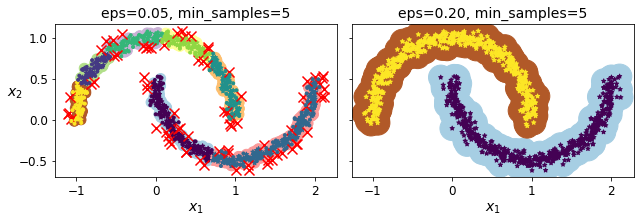

In [231]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


As you can see, it
identified quite a lot of anomalies, plus seven different clusters. Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get
the clustering on the right, which looks perfect

Somewhat surprisingly, the DBSCAN class does not have a predict() method, although
it has a fit_predict() method. In other words, **it cannot predict which cluster a new
instance belongs to**. This implementation decision was made because different classification
algorithms can be better for different tasks, so the authors decided to let the
user choose which one to use. Moreover, it’s not hard to implement. For example, let’s
train a **KNeighborsClassifier**. 
For more info: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [232]:
dbscan = dbscan2

In [233]:
from sklearn.neighbors import KNeighborsClassifier

We train the classifier on the core instances

In [234]:
knn = KNeighborsClassifier(n_neighbors=50)
#knn.fit(X,y)as alternative
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [235]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [236]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


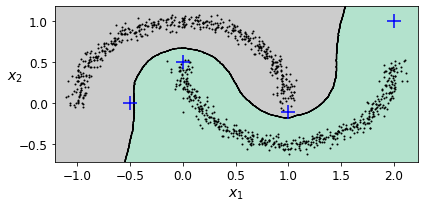

In [237]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In short, DBSCAN is a very simple yet powerful algorithm capable of identifying any
number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters
(eps and min_samples). If the density varies significantly across the clusters,
however, it can be impossible for it to capture all the clusters properly